## Static training

In [3]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nptdms import TdmsFile #Process ramping file

#For building ML models
import keras
import keras.models as models
from keras.layers.core import Dense
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.signal import find_peaks

np.random.seed(1337) # for reproducibility


Bad key "text.kerning_factor" on line 4 in
/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


In [18]:
def load_sensor(dir_path, sensor, time_range = None):
    
    data = pd.DataFrame(data = {sensor: np.load(dir_path + sensor + ".npy"),
                                "time": np.load(dir_path + "time.npy")})
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    data = data[(data["time"] > start) & (data["time"] < end)]
   
    %reset -f in
    
    return data[sensor]

def load_time_label(dir_path, time_range, window = 2000, step = 10):
    
    time_label =  np.load(dir_path + "time.npy")
    
    start = min(time_label)
    end = max(time_label)
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    time_label = time_label[(time_label > start) & (time_label < end)][window-1::step]
    
    %reset -f in
    
    return time_label

#### Mean of abs(signal)
def generate_mean_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_mean = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_mean

#### SD of signal
def generate_sd_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_sd = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_sd

#### Thresholded zero crossings
def zero_crossings(array):
    
    #Set values outside of range (0.001, 0.1) = 0
    array[abs(array) > 0.1] = 0
    array[abs(array) < 0.005] = 0
    
    #Calculate number of zero-crossing points, normalized by the window size
    zero_crossings = ((array[:-1] * array[1:]) < 0).sum()/array.size
    
    return zero_crossings


def generate_crossings_data(dir_path, time_range = None, window = 5000, step = 10):
    
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_crossings = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_crossings


def generate_data(dir_path, time_range, window = 2000, thres_win = 25000, step = 10):
    
    #Selection index due to using different window
    selection_index = int((thres_win - window)/step)
    
    moving_mean = generate_mean_data(dir_path, time_range, window = window, step = step)[selection_index:]
    moving_sd = generate_sd_data(dir_path, time_range, window = window, step = step)[selection_index:]
    #moving_thres_crossings = generate_crossings_data(dir_path, time_range, window = thres_win, step = step)
    time_label = load_time_label(dir_path, time_range, window = window, step = step)[selection_index:]
    
    all_data = np.concatenate((moving_mean, moving_sd), axis = 1)
    
    print("All data's shape: ", all_data.shape)
    
    %reset -f in
    
    return all_data, time_label

#####-------INCREMENTAL LEARNING IMPLEMENTATION-------######

def create_model():
    
    #================BUILD THE MODEL====================
    # Simple model
    # Simple model
    model = models.Sequential()

    model.add(Dense(6, activation = 'elu', kernel_initializer='glorot_uniform',
                    kernel_regularizer=regularizers.l2(0.0),
                    input_dim=12))

    model.add(Dense(3,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(6,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(12,
                    kernel_initializer='glorot_uniform'))

    model.compile(loss='mse',optimizer='adam')


    return model

def train(X, time_axis, time_range):
    """Take a model, train it in the appropritate time range, return the new weights
    and its reconstruction loss distribution"""
    
    print("Training for section: ", time_range)
    #Select the appropriate time
    start_index = None
    
    if time_range[0] is not None:
        start_index = np.argmax(time_axis > time_range[0])
    else:
        start_index = 0
    
    if time_range[1] == 0:
        end_index = None
    else:
        end_index = np.argmax(time_axis > time_range[1])
    
    X_train = np.copy(X[start_index:end_index])
    time_train = time_axis[start_index:end_index]
    
    #Create model
    model = create_model()
    
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    
    #Train the model and extract new weights
    model.fit(X_train, X_train,
              batch_size=2000,
              epochs=30, verbose = 0)
    
    new_weights = model.get_weights()
    
    #Evaluate the losses and update the distribution
    X_pred = model.predict(X_train)
    loss = np.mean(np.abs(X_pred-X_train), axis = 1)
    
    #Plot the reconstruction loss
    plt.figure(figsize=(20,2))
    plt.plot(time_train, loss)
    plt.title("TRAINING reconstruction loss on {}".format(time_range))
    plt.xlabel("Time [s]")
    plt.show()
    
    #Take the mean of the log loss and update the mean threshold
    current_median = np.median(np.log10(loss))
    
    print("Finished training, median of the log(loss) is: ", current_median)
    
    return new_weights, current_median, scaler

def trigger(current_weights, X, time_axis, time_range, prev_median, scaler):
    
    print("Triggering for section: ", time_range)
    print("Using this median for triggering:", prev_median)
    
    #Select the appropriate time
    start_index = None
    
    if time_range[0] is not None:
        start_index = np.argmax(time_axis > time_range[0])
    else:
        start_index = 0
    
    if time_range[1] == 0:
        end_index = None
    else:
        end_index = np.argmax(time_axis > time_range[1])
    
    time_test = time_axis[start_index:end_index]
    X_test = np.copy(X[start_index:end_index])
    
    X_test = scaler.transform(X_test) #Scale the current data
    
    #Create model
    model = create_model()
    model.set_weights(current_weights)
        
    #Find the test loss (doing this in parallel for the sake of simulation), but in a practical system
    #Ideally we need to do inference every single data point come in
    X_pred_test = model.predict(X_test)
    test_loss = np.mean(np.abs(X_pred_test-X_test), axis = 1)
    
    
    #Plot the reconstruction loss just to check
    plt.figure(figsize=(20,2))
    plt.plot(time_test, test_loss)
    plt.title("Reconstruction loss", fontsize = 20)
    plt.xlabel("Time [s]", fontsize = 20)
    plt.ylabel("Loss", fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.show()
    
    #Quantify how much each data point is far away from the distribution
    log_test_loss = np.log10(test_loss) - prev_median
    
    #Find the trigger time
    trigger_index = np.argmax(log_test_loss > 3.3)
    
    if  trigger_index != 0:
        #Plot the triggered time
        plt.figure(figsize=(20,2))
        plt.plot(time_test, log_test_loss, color = "firebrick")
        plt.title(r"$log_{10}$(loss)", fontsize = 20)
        plt.xlabel("Time [s]", fontsize = 20)
        plt.ylabel("Log loss", fontsize = 20)
        plt.xticks(fontsize = 15)
        plt.yticks(fontsize = 15)
        
        #Trigger time
        plt.vlines(time_test[trigger_index], log_test_loss.min(), log_test_loss.max(), color = "blue", linestyles = "dashed", label = "Trigger time")
        plt.legend(loc = "upper left", fontsize=17)
        
        
        ### Find trigger times
        peaks, _ = find_peaks(log_test_loss, height=3.3, distance = 5000)
        print("Other trigger time: ", time_test[peaks])
        print("Their log loss values are: ", log_test_loss[peaks])
        
        for i in range(len(peaks)):
            plt.vlines(time_test[peaks[i]], log_test_loss.min(), log_test_loss.max(), color = "blue", linestyles = "dashed")
            
        plt.show()
        
        return list(time_test[peaks])
    
    else:
        return None
    

def simulation(dir_path, section_size, time_range):
    
    #Load data and create the model
    X, time_axis = generate_data(dir_path, time_range = time_range, window = 2000, step = 10)
    
    #Calculate the training and the triggering time. 
    training_range = (time_range[0], time_range[0] + section_size)
    trigger_range = ( time_range[0] + section_size, time_range[1])
        
    #Train and then trigger
    train_weights, train_median, train_scaler = train(X, time_axis, training_range)
    trigger_time = trigger(train_weights, X, time_axis, trigger_range, train_median, train_scaler)
            
    if trigger_time is not None:
        print("Triggered at: ", trigger_time)

## 3.3 threshold

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (897500, 12)
Flushing input history
Training for section:  (-90, -80)


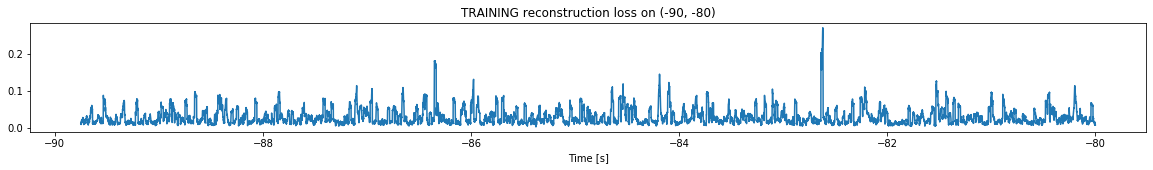

Finished training, median of the log(loss) is:  -1.6488117273787737
Triggering for section:  (-80, 0)
Using this median for triggering: -1.6488117273787737


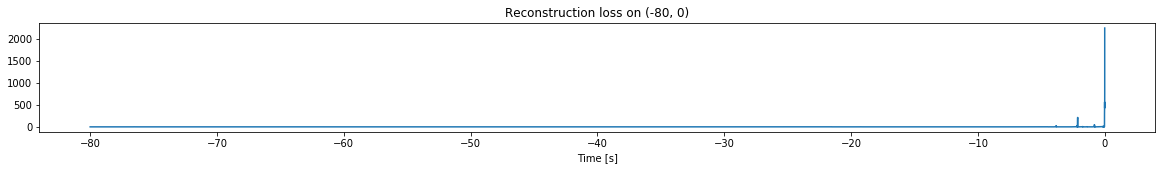

Other trigger time:  [-2.1325998 -0.8125    -0.006    ]
Their log loss values are:  [3.97758204 3.34659462 4.39944876]


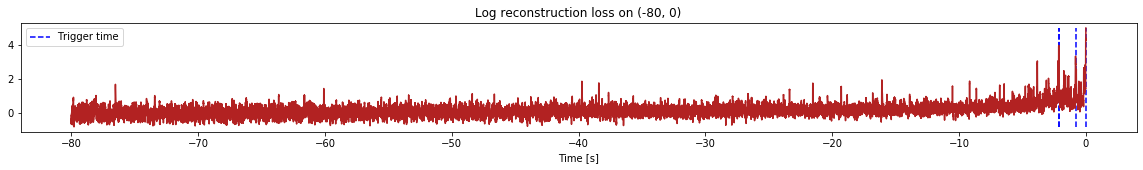

Triggered at:  [-2.1325998, -0.8125, -0.006]


In [3]:
simulation("./data/Ramp4/", 10, (-90,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (897500, 12)
Flushing input history
Training for section:  (-90, -80)


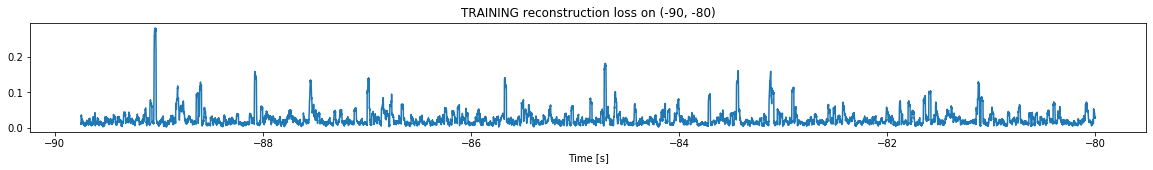

Finished training, median of the log(loss) is:  -1.7129279667583908
Triggering for section:  (-80, 0)
Using this median for triggering: -1.7129279667583908


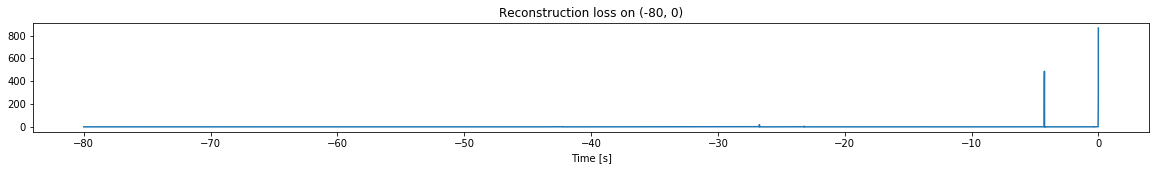

Other trigger time:  [-4.251  -0.0135]
Their log loss values are:  [4.40043205 3.76888969]


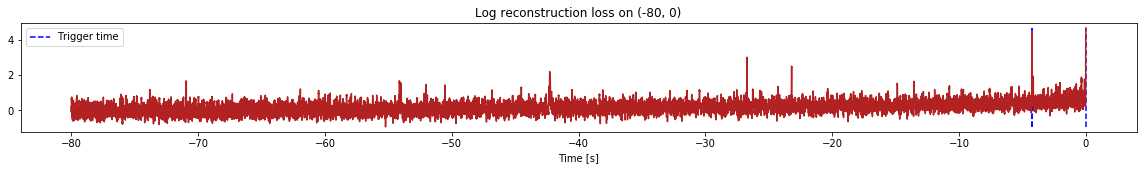

Triggered at:  [-4.251, -0.013499999]


In [4]:
simulation("./data/Ramp5/", 10, (-90,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (997500, 12)
Flushing input history
Training for section:  (-100, -90)


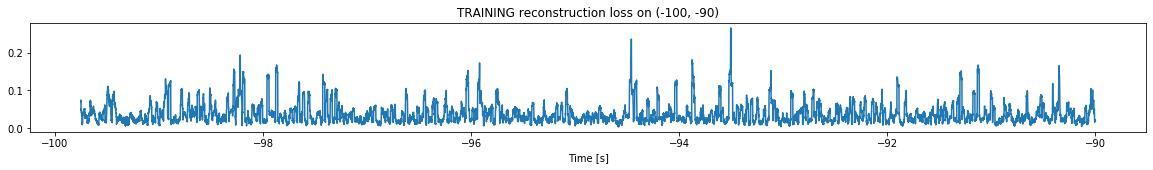

Finished training, median of the log(loss) is:  -1.5173961368550757
Triggering for section:  (-90, 0)
Using this median for triggering: -1.5173961368550757


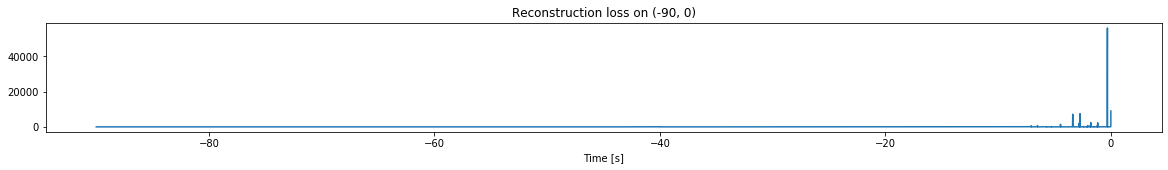

Other trigger time:  [-39.950897   -7.0541997  -6.5119996  -5.2644     -4.4707     -3.3790998
  -2.731      -1.7816999  -1.1642     -0.3037   ]
Their log loss values are:  [3.32229444 4.34072393 4.37770056 3.66608215 4.67692995 5.37130674
 5.3925762  4.9089127  4.88147133 6.26639454]


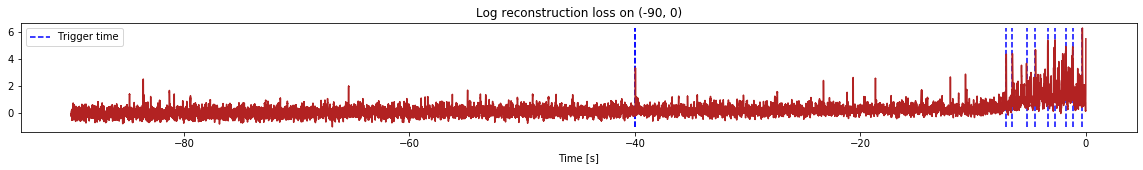

Triggered at:  [-39.950897, -7.0541997, -6.5119996, -5.2644, -4.4707, -3.3790998, -2.731, -1.7816999, -1.1642, -0.3037]


In [5]:
simulation("./data/Ramp12d/", 10, (-100,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (2997500, 12)
Flushing input history
Training for section:  (-300, -290)


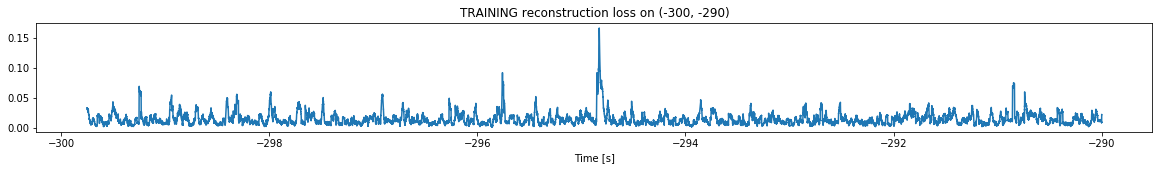

Finished training, median of the log(loss) is:  -1.8989466062206493
Triggering for section:  (-290, 0)
Using this median for triggering: -1.8989466062206493


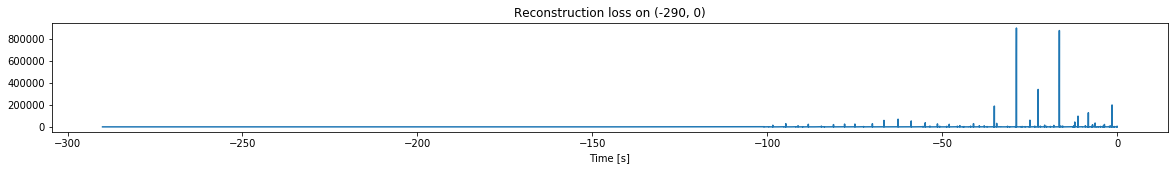

Other trigger time:  [-1.00912491e+02 -9.95395889e+01 -9.84124908e+01 -9.73240891e+01
 -9.52236862e+01 -9.47041855e+01 -9.25302887e+01 -9.18037872e+01
 -9.11938858e+01 -8.98854904e+01 -8.82621841e+01 -8.72975845e+01
 -8.53527908e+01 -8.45351868e+01 -8.36727905e+01 -8.25480881e+01
 -8.16247864e+01 -8.10654907e+01 -8.02503891e+01 -7.94675903e+01
 -7.85141907e+01 -7.78930893e+01 -7.63075867e+01 -7.49471893e+01
 -7.42643890e+01 -7.36461868e+01 -7.24836884e+01 -7.13543854e+01
 -7.07365875e+01 -6.99491882e+01 -6.91439896e+01 -6.83192902e+01
 -6.66418915e+01 -6.58401871e+01 -6.46908875e+01 -6.41395874e+01
 -6.33638878e+01 -6.26035881e+01 -6.12661896e+01 -5.96576881e+01
 -5.88482895e+01 -5.82306900e+01 -5.72216873e+01 -5.62733879e+01
 -5.54742889e+01 -5.48389893e+01 -5.35070877e+01 -5.25217896e+01
 -5.13517876e+01 -5.06838875e+01 -4.95708885e+01 -4.87000885e+01
 -4.79804878e+01 -4.68831902e+01 -4.63370895e+01 -4.56673889e+01
 -4.49505882e+01 -4.37937889e+01 -4.31181908e+01 -4.24879875e+01
 -4.

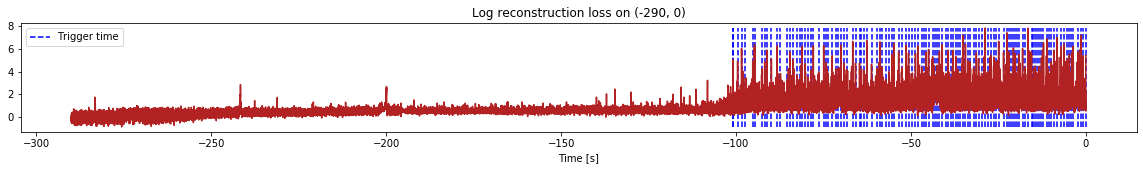

Triggered at:  [-100.91249, -99.53959, -98.41249, -97.32409, -95.22369, -94.704185, -92.53029, -91.80379, -91.193886, -89.88549, -88.262184, -87.297585, -85.35279, -84.53519, -83.67279, -82.54809, -81.62479, -81.06549, -80.25039, -79.46759, -78.51419, -77.89309, -76.30759, -74.94719, -74.26439, -73.64619, -72.48369, -71.354385, -70.73659, -69.94919, -69.14399, -68.31929, -66.64189, -65.84019, -64.69089, -64.13959, -63.363888, -62.60359, -61.26619, -59.65769, -58.84829, -58.23069, -57.221687, -56.273388, -55.47429, -54.83899, -53.507088, -52.52179, -51.351788, -50.683887, -49.57089, -48.70009, -47.980488, -46.88319, -46.33709, -45.66739, -44.95059, -43.79379, -43.11819, -42.487988, -41.86549, -41.042988, -39.99769, -39.38839, -38.656387, -37.988888, -37.16359, -36.62309, -35.92389, -35.09139, -34.41839, -33.75879, -33.14719, -32.100887, -31.300388, -30.66589, -29.79699, -28.77579, -27.92219, -27.11109, -26.28809, -25.665289, -24.92079, -23.52949, -22.56219, -21.94479, -21.44389, -20.705

In [7]:
simulation("./data/Ramp19/", 10, (-300,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (2117500, 12)
Flushing input history
Training for section:  (-212, -202)


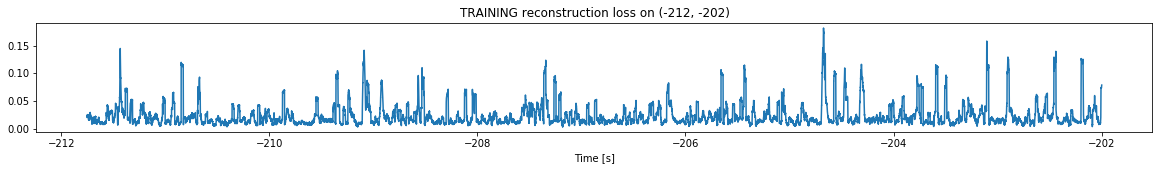

Finished training, median of the log(loss) is:  -1.7712316039806772
Triggering for section:  (-202, 0)
Using this median for triggering: -1.7712316039806772


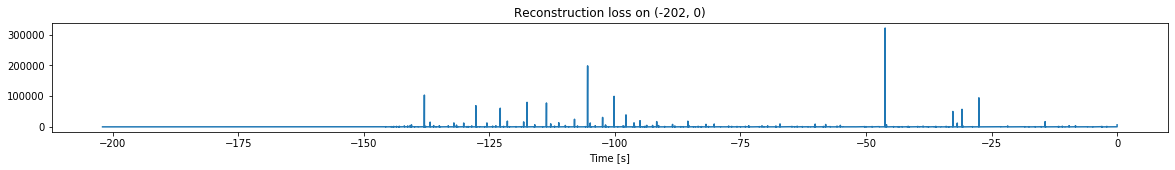

Other trigger time:  [-190.83348    -148.10109    -146.59138    -145.6043     -144.52678
 -144.02179    -143.47359    -142.9188     -141.91309    -141.23909
 -140.48679    -139.85579    -139.14058    -137.92479    -136.77028
 -136.0718     -134.94579    -134.11528    -133.17009    -132.0474
 -131.52489    -130.09099    -129.42918    -128.48648    -127.66999
 -126.89019    -126.161285   -125.471085   -124.32478    -123.685585
 -122.81489    -122.138885   -121.40079    -120.54049    -119.67489
 -118.85278    -118.15259    -117.48109    -116.77109    -115.938286
 -114.35469    -113.617584   -112.767784   -111.99669    -111.169586
 -109.85689    -109.17109    -108.03278    -107.43809    -106.89869
 -105.42019    -104.89479    -103.90439    -102.43589    -101.85869
 -101.25249    -100.15279     -99.417786    -98.363884    -97.78399
  -96.18239     -94.986885    -94.380684    -93.642685    -92.48369
  -91.66539     -90.07129     -88.50999     -86.859985    -85.46389
  -84.35319     -83.41709

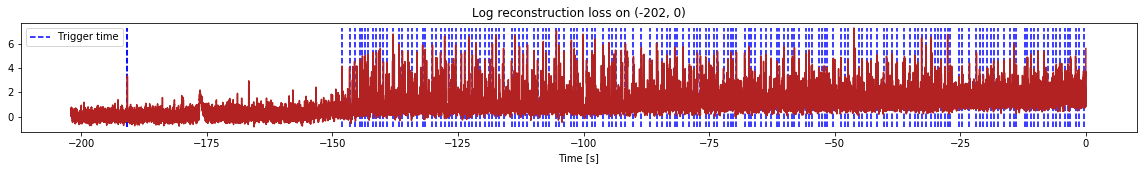

Triggered at:  [-190.83348, -148.10109, -146.59138, -145.6043, -144.52678, -144.02179, -143.47359, -142.9188, -141.91309, -141.23909, -140.48679, -139.85579, -139.14058, -137.92479, -136.77028, -136.0718, -134.94579, -134.11528, -133.17009, -132.0474, -131.52489, -130.09099, -129.42918, -128.48648, -127.66999, -126.89019, -126.161285, -125.471085, -124.32478, -123.685585, -122.81489, -122.138885, -121.40079, -120.54049, -119.67489, -118.85278, -118.15259, -117.48109, -116.77109, -115.938286, -114.35469, -113.617584, -112.767784, -111.99669, -111.169586, -109.85689, -109.17109, -108.03278, -107.43809, -106.89869, -105.42019, -104.89479, -103.90439, -102.43589, -101.85869, -101.25249, -100.15279, -99.417786, -98.363884, -97.78399, -96.18239, -94.986885, -94.380684, -93.642685, -92.48369, -91.66539, -90.07129, -88.50999, -86.859985, -85.46389, -84.35319, -83.41709, -82.75199, -81.85859, -81.35429, -80.21699, -78.93199, -78.036385, -77.336586, -76.72739, -75.68049, -74.980385, -74.01739, -

In [8]:
simulation("./data/Ramp20/", 10, (-212,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (1197500, 12)
Flushing input history
Training for section:  (-120, -110)


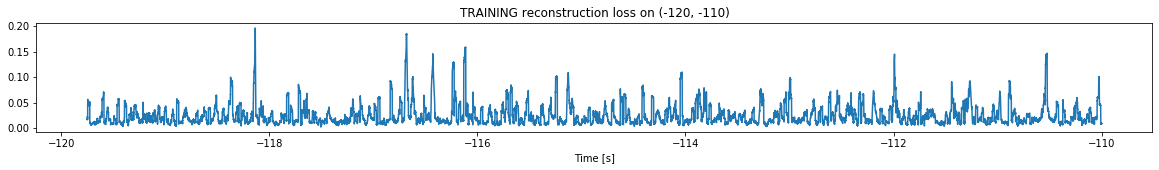

Finished training, median of the log(loss) is:  -1.7211126330573268
Triggering for section:  (-110, 0)
Using this median for triggering: -1.7211126330573268


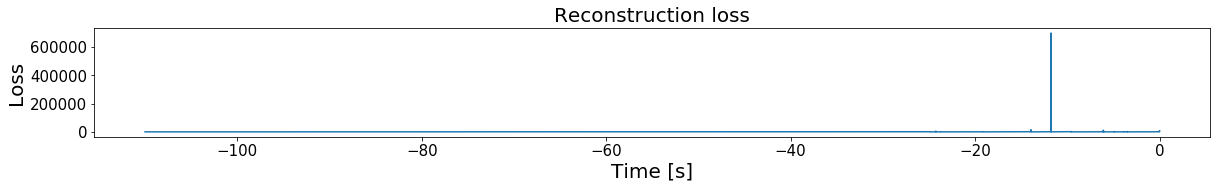

Other trigger time:  [-41.1455    -39.2193    -36.6991    -33.379498  -30.5548    -29.4622
 -24.8527    -24.255999  -23.7023    -22.5403    -21.855     -20.4692
 -19.1218    -17.934     -17.1343    -16.0494    -14.9689    -13.9534
 -11.759     -10.9154     -9.599299   -8.3621     -7.2702     -6.1043
  -4.9003     -3.4945     -2.1564999  -1.3729     -0.4114   ]
Their log loss values are:  [3.47517894 3.83341431 4.43164912 3.89707335 3.34591835 3.52867998
 4.74318843 5.44722043 4.61859214 3.45464226 3.99309692 4.21130184
 4.47562986 3.72529043 4.51753994 4.37376959 4.64204634 5.90206133
 7.5667348  3.54787099 5.14587711 4.24476969 4.56719911 5.79107042
 4.89137133 5.07216874 3.82838763 3.46290957 3.50252319]


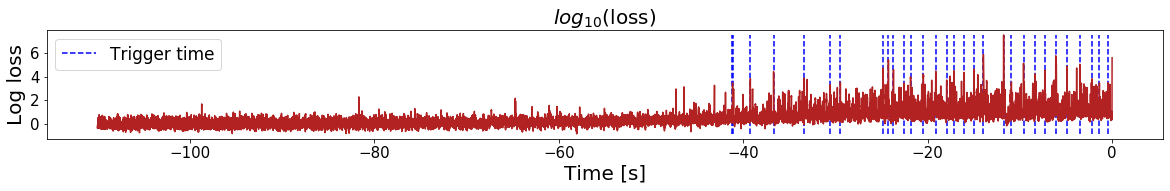

Triggered at:  [-41.1455, -39.2193, -36.6991, -33.379498, -30.5548, -29.4622, -24.8527, -24.255999, -23.7023, -22.5403, -21.855, -20.4692, -19.1218, -17.934, -17.1343, -16.0494, -14.9689, -13.9534, -11.759, -10.9154, -9.599299, -8.3621, -7.2702, -6.1043, -4.9003, -3.4945, -2.1564999, -1.3729, -0.4114]


In [21]:
simulation("./data/Ramp21/", 10, (-120,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (797500, 12)
Flushing input history
Training for section:  (-80, -70)


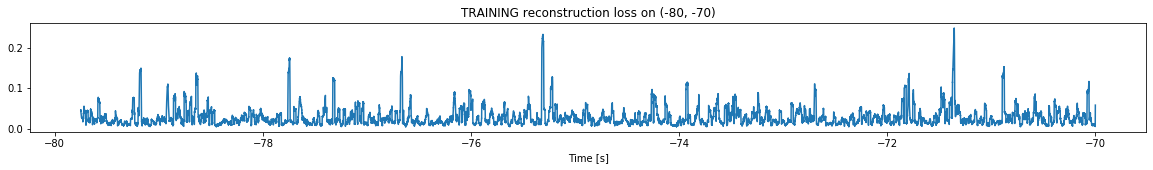

Finished training, median of the log(loss) is:  -1.6482188887763418
Triggering for section:  (-70, 0)
Using this median for triggering: -1.6482188887763418


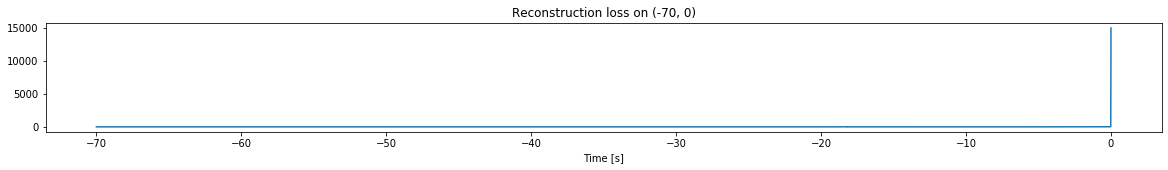

Other trigger time:  []
Their log loss values are:  []


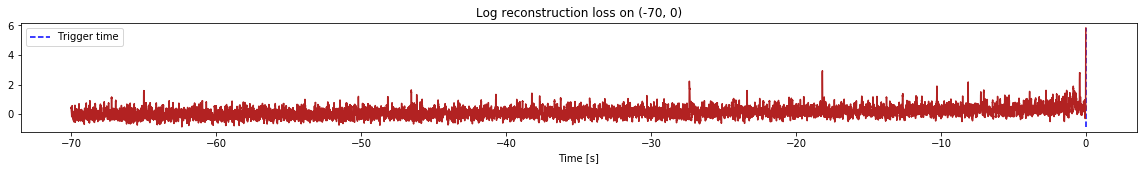

Triggered at:  []


In [10]:
simulation("./data/Ramp22/", 10, (-80,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (497500, 12)
Flushing input history
Training for section:  (-50, -40)


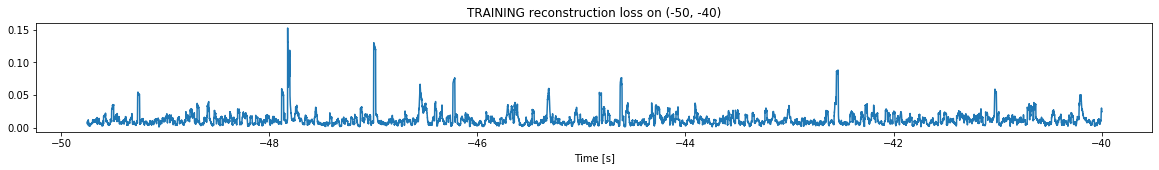

Finished training, median of the log(loss) is:  -1.9708161257375136
Triggering for section:  (-40, 0)
Using this median for triggering: -1.9708161257375136


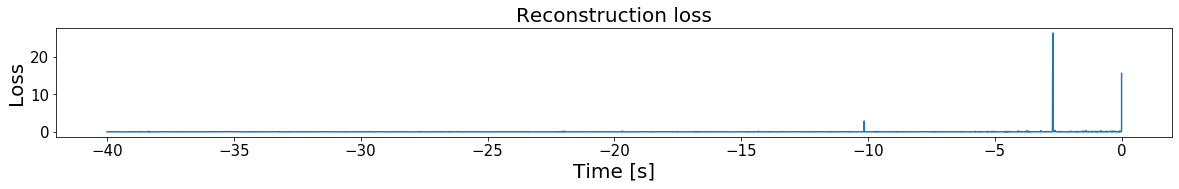

Other trigger time:  [-2.7054]
Their log loss values are:  [3.39244603]


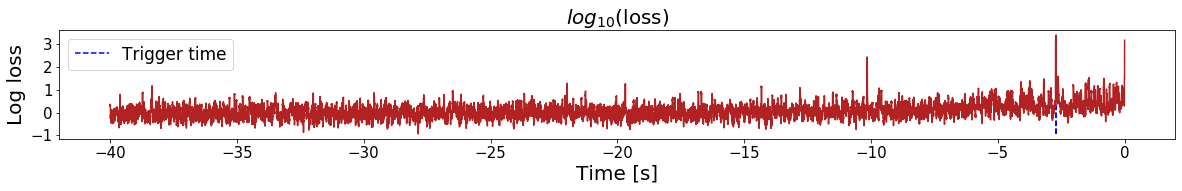

Triggered at:  [-2.7054]


In [20]:
simulation("./data/Ramp23/", 10, (-50,0))

In [ ]:
simulation("./data/Ramp24/", 10, (-110,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (997500, 12)
Flushing input history
Training for section:  (-100, -90)


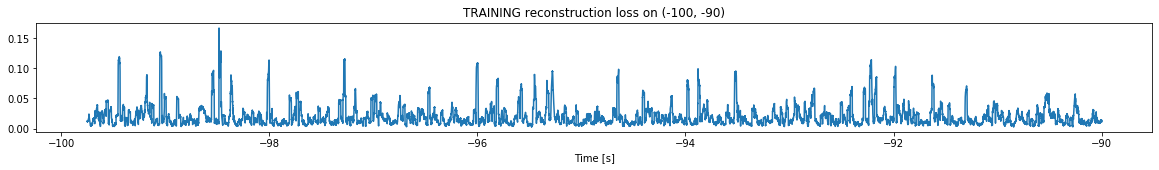

Finished training, median of the log(loss) is:  -1.8127245163780983
Triggering for section:  (-90, 0)
Using this median for triggering: -1.8127245163780983


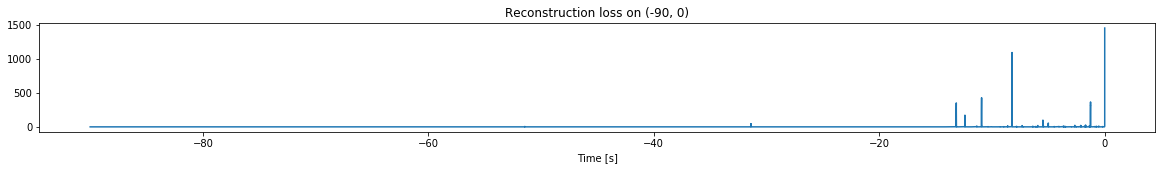

Other trigger time:  [-31.3849    -13.1676    -12.4017    -10.922299   -8.2217     -5.4825
  -1.2574999]
Their log loss values are:  [3.4852655  4.36035926 4.0487733  4.44575526 4.85287568 3.80940483
 4.37790712]


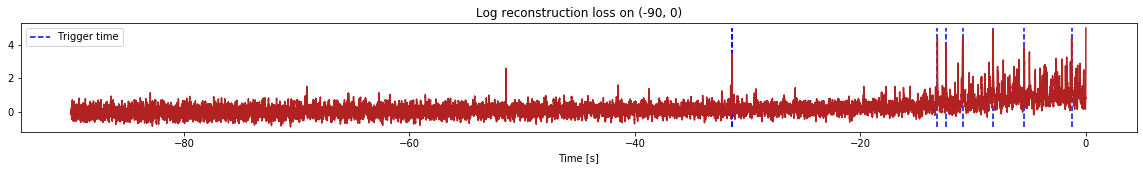

Triggered at:  [-31.3849, -13.1676, -12.4017, -10.922299, -8.2217, -5.4825, -1.2574999]


In [13]:
simulation("./data/Ramp25/", 10, (-100,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (1097500, 12)
Flushing input history
Training for section:  (-110, -100)


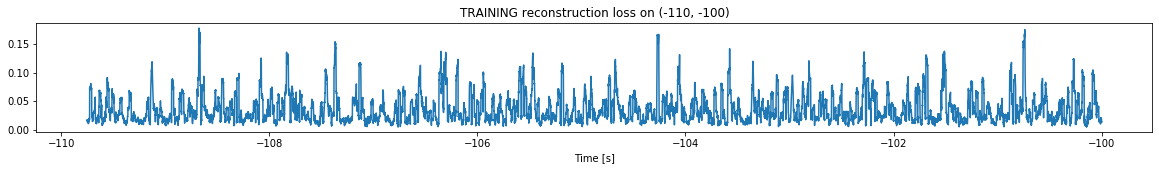

Finished training, median of the log(loss) is:  -1.526967445148046
Triggering for section:  (-100, 0)
Using this median for triggering: -1.526967445148046


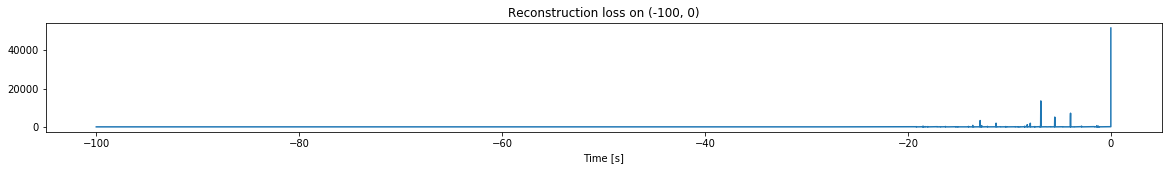

Other trigger time:  [-19.1645    -18.4714    -17.112     -16.3121    -15.2653    -14.191099
 -13.608     -12.8805    -12.1662    -11.3139    -10.3625     -9.4227
  -8.486199   -7.9374     -6.9013     -5.5269     -4.7117     -3.9722
  -2.8878999  -1.3776   ]
Their log loss values are:  [3.53771039 3.96187057 3.48934837 3.83068277 3.45156357 3.36820453
 4.41082803 5.04523069 3.93477406 4.80667161 3.74271481 3.53441607
 4.04161444 4.80302939 5.65881282 5.23434029 3.32344406 5.37995551
 4.09290626 4.31210282]


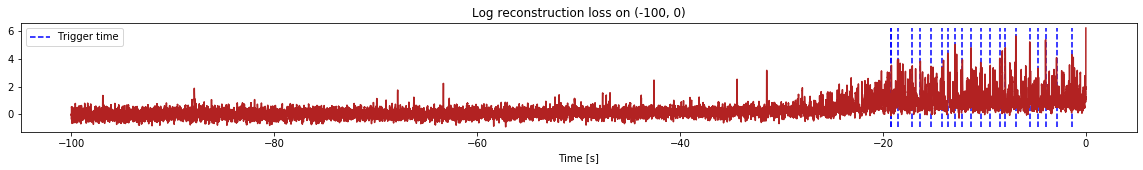

Triggered at:  [-19.1645, -18.4714, -17.112, -16.3121, -15.2653, -14.191099, -13.608, -12.8805, -12.1662, -11.3139, -10.3625, -9.4227, -8.486199, -7.9374, -6.9013, -5.5269, -4.7117, -3.9722, -2.8878999, -1.3776]


In [14]:
simulation("./data/Ramp26/", 10, (-110,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (697500, 12)
Flushing input history
Training for section:  (-70, -60)


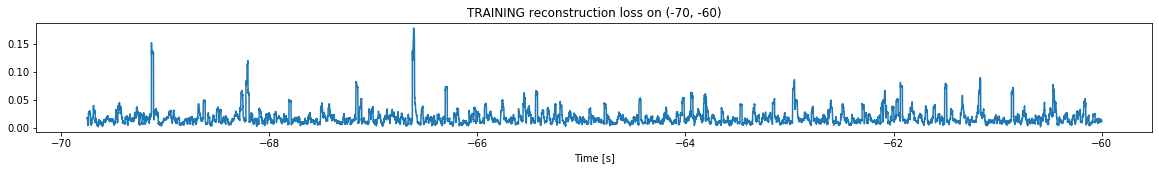

Finished training, median of the log(loss) is:  -1.8239076023864103
Triggering for section:  (-60, 0)
Using this median for triggering: -1.8239076023864103


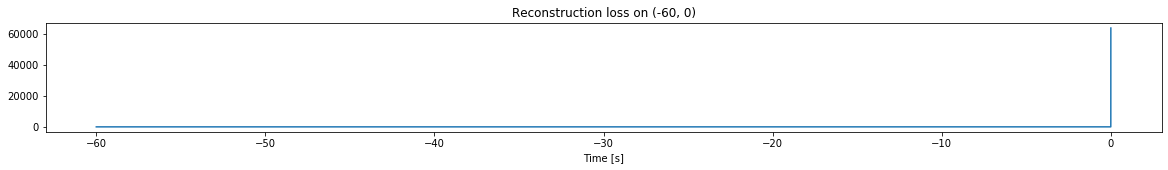

Other trigger time:  []
Their log loss values are:  []


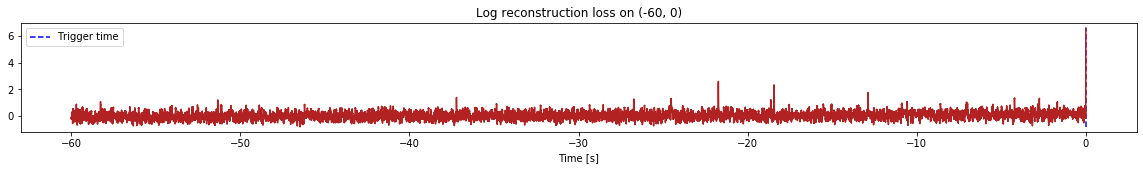

Triggered at:  []


In [15]:
simulation("./data/Ramp27/", 10, (-70,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (597500, 12)
Flushing input history
Training for section:  (-60, -50)


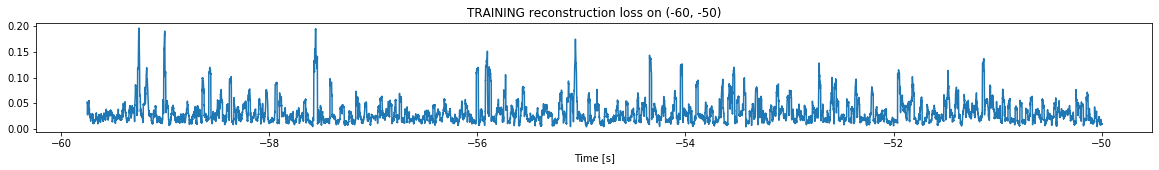

Finished training, median of the log(loss) is:  -1.5821349253287156
Triggering for section:  (-50, 0)
Using this median for triggering: -1.5821349253287156


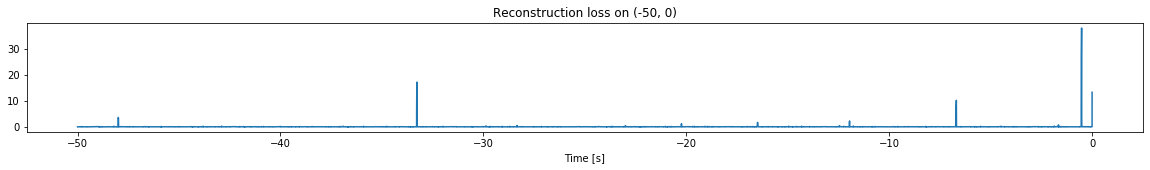

In [16]:
simulation("./data/Ramp28/", 10, (-60,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (997500, 12)
Flushing input history
Training for section:  (-100, -90)


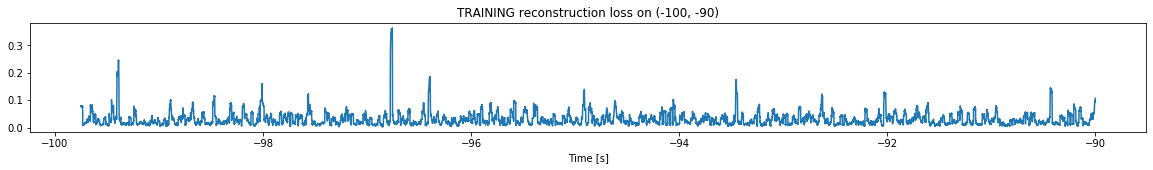

Finished training, median of the log(loss) is:  -1.6136031760156873
Triggering for section:  (-90, 0)
Using this median for triggering: -1.6136031760156873


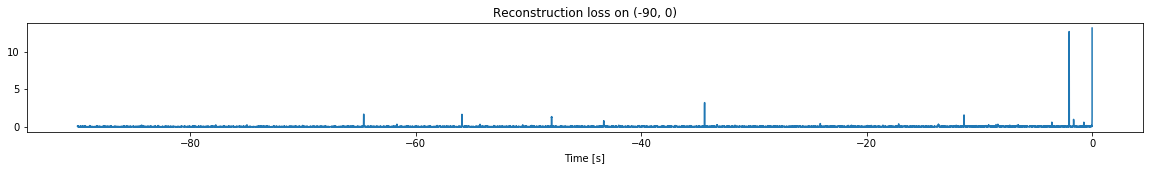

In [17]:
simulation("./data/Ramp29/", 10, (-100,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (1197500, 12)
Flushing input history
Training for section:  (-120, -110)


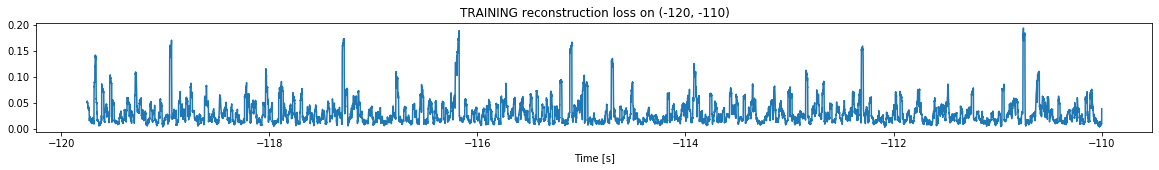

Finished training, median of the log(loss) is:  -1.6015606241223215
Triggering for section:  (-110, 0)
Using this median for triggering: -1.6015606241223215


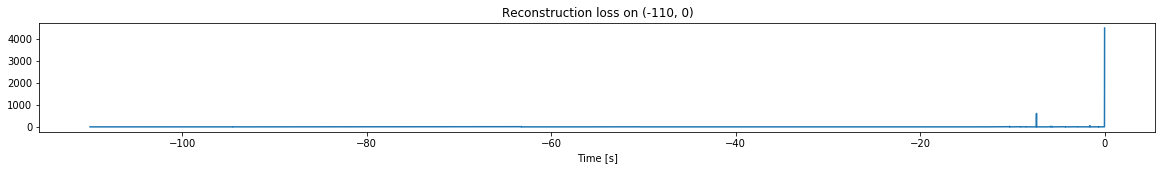

Other trigger time:  [-7.3820996 -1.5870999]
Their log loss values are:  [4.38435959 3.32361948]


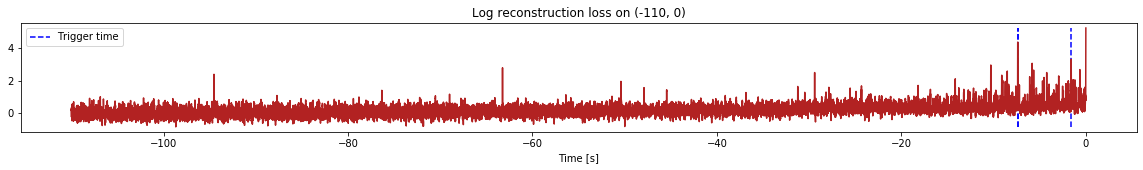

Triggered at:  [-7.3820996, -1.5870999]


In [18]:
simulation("./data/Ramp30/", 10, (-120,0))

## 3.5 threshold

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text yticklabel objects>)

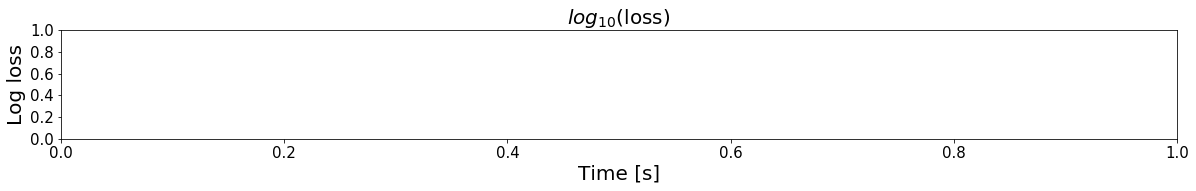

In [15]:
 #Plot the triggered time
plt.figure(figsize=(20,2))
#plt.plot(time_test, log_test_loss, color = "firebrick")
plt.title(r"$log_{10}$(loss)", fontsize = 20)
plt.xlabel("Time [s]", fontsize = 20)
plt.ylabel("Log loss", fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)